In [4]:
from bs4 import BeautifulSoup
from tqdm import tqdm
import requests
import csv
import re
import pandas as pd

def getAndParseURL(url):
    result = requests.get(url)
    soup = BeautifulSoup(result.text, 'html.parser')
    return(soup)

def get_appearances(pokemon_soup):
    names = [table_name.get('href')[1:] for table_name in pokemon_soup.find('p').findAll('a')]
    regex = re.compile('key.*')
    appearances,i = {},0
    for table in pokemon_soup.findAll("table"):
        lines = table.findAll("td",{"class":regex})
        if len(lines) > 0:
            appearances[names[i]] = [line.text for line in lines]        
            i += 1
    return appearances

def dexnum(base_url):
    bulbasoup = getAndParseURL(base_url+'001.shtml')
    tuples=re.findall(r'\n([0-9]{3})\ +(\w+.*\w+)',bulbasoup.text)
    return {int(num_str):name for num_str,name in tuples}
        

In [426]:
base = 'https://www.serebii.net/anime/dex/'
dex = dexnum(base)
AppDict = {poke:get_appearances(getAndParseURL(f'{base}{num:03}.shtml')) for num,poke in tqdm(dex.items())}


100%|████████████████████████████████████████████| 898/898 [05:25<00:00,  2.76it/s]


In [436]:
poke = pd.DataFrame(AppDict)
poke.to_csv('temp')
poke = pd.read_csv('temp',index_col=0)

In [471]:
from collections import defaultdict
d = defaultdict(list)

for poke,group in tqdm(AppDict.items()):
    for title,eps in group.items():
        for ep in eps:
            d[ep].append((poke,title))

100%|█████████████████████████████████████████| 898/898 [00:00<00:00, 75532.13it/s]


In [476]:
eps = pd.Series(d)
exploded = eps.to_frame().explode(0)
episodes = pd.DataFrame(data=exploded[0].to_list(),index=exploded.index,columns=['Pokemon','sub'])
episodes.to_csv('epslist')

In [6]:
eps = pd.read_csv('epslist',index_col=0)

In [274]:
wild = eps[eps['sub']=='wild']
anime = eps[eps.index.str.isdigit()]
anime.index = pd.to_numeric(anime.index)
anime = anime.sort_index()

In [317]:
extanime = anime[anime['sub'].isin(['wild','special/othertrainers'])].copy()
extanime['First'] = extanime.groupby('Pokemon').transform(lambda x:x.index.min())
extanime.index.name = 'episode'
extanime = extanime.reset_index()
extanime = extanime.infer_objects()
extanime['diffs']=extanime.groupby('Pokemon')['episode'].diff().fillna(0).astype(int)
ea=extanime

In [318]:
# For the different generations of pokemon [G1,G2,...]
sn_fn = [118,276,468,659,801,941,1087]

In [319]:
g1 = extanime[extanime.episode<sn_fn[0]]

<AxesSubplot:xlabel='diffs', ylabel='Count'>

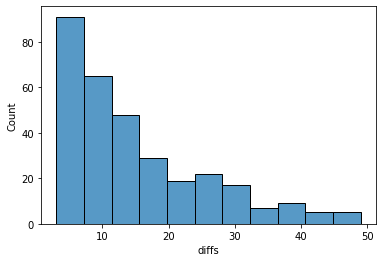

In [320]:
sns.histplot(g1.diffs[(g1.diffs>2)&(g1.diffs<50)])

In [379]:
gen = 6
premier = ea[((ea.First<sn_fn[gen-1])&(ea.First>sn_fn[gen-2]))&((ea.episode<sn_fn[gen-1])&(ea.episode>sn_fn[gen-2]))]
previous = ea[(ea.First<sn_fn[gen-2])&((ea.episode<sn_fn[gen-1])&(ea.episode>sn_fn[gen-2]))]
print(previous[previous.diffs>2])
print(premier[premier.diffs>2])

      episode    Pokemon                    sub  First  diffs
4008      802    Slowbro                   wild     17    540
4009      802     Pidgey                   wild      1    158
4010      802   Slowpoke                   wild     17    152
4011      802   Magikarp                   wild      1    183
4012      802   Gyarados                   wild      1    196
...       ...        ...                    ...    ...    ...
5123      940    Psyduck                   wild    124     22
5124      940    Machamp  special/othertrainers     29     86
5125      940     Marill                   wild    148     10
5126      940  Zigzagoon                   wild    274     16
5127      940    Linoone                   wild    432     69

[708 rows x 5 columns]
      episode     Pokemon                    sub  First  diffs
4144      811     Furfrou  special/othertrainers    804      6
4166      813  Helioptile                   wild    805      8
4172      814     Pangoro                  